In [0]:
import pandas as pd
import numpy as np

In [0]:
output = []
for t in range(2):
  for snum in range(256):
    f = pd.read_csv('https://raw.githubusercontent.com/jortizta/atmos-neuralnet/master/data/train_t_'+str(t).zfill(2)+'_slice_'+str(snum).zfill(3)+'.csv', header=None)
    output.append(f.values)
output = np.array(output)

In [0]:
train = output[:,0:5,0:128]
target = output[:,5:,0:128]

In [0]:
output2 = []
for t in range(0,5):
  for snum in range(256):
    f = pd.read_csv('train_t_'+str(t).zfill(2)+'_slice_'+str(snum).zfill(3)+'.csv', header=None)
    output2.append(f.values)
output2 = np.array(output2)

In [67]:
output2.shape

(1280, 7, 131)

In [0]:
validation = output2[:,0:5,0:128]
target_val = output2[:,5:,0:128]

In [0]:
train = train[:,:,:,np.newaxis]
target = target[:,:,:,np.newaxis]
validation = validation[:,:,:,np.newaxis]
target_val = target_val[:,:,:,np.newaxis]

In [63]:
target.shape

(512, 2, 128, 1)

In [34]:
!git clone https://github.com/jortizta/atmos-neuralnet.git

Cloning into 'atmos-neuralnet'...
remote: Enumerating objects: 2851, done.
remote: Counting objects: 100% (2851/2851), done.
remote: Compressing objects: 100% (2845/2845), done.
remote: Total 2851 (delta 7), reused 2839 (delta 3), pack-reused 0
Receiving objects: 100% (2851/2851), 23.67 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [111]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/jortizta/atmos-neuralnet
   8984f2b..842fa66  master     -> origin/master
Updating 8984f2b..842fa66
Fast-forward
 src/dataset.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [0]:
from net import TurbNetG, weights_init

In [0]:
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import dataset

In [0]:
######## Settings ########

# number of training iterations
iterations = 10000
# batch size
batch_size = 10
# learning rate, generator
lrG = 0.0006
# decay learning rate?
decayLr = True
# channel exponent to control network size
expo = 5
# data set config
prop=None # by default, use all from "../data/train"
#prop=[1000,0.75,0,0.25] # mix data from multiple directories
# save txt files with per epoch loss?
saveL1 = False

In [115]:
##########################

#prefix = ""
#if len(sys.argv)>1:
#    prefix = sys.argv[1]
#    print("Output prefix: {}".format(prefix))

# autoIter   = False
# dropout    = 0.
# doLoad     = ""

# print("LR: {}".format(lrG))
# print("LR decay: {}".format(decayLr))
# print("Iterations: {}".format(iterations))
# print("Dropout: {}".format(dropout))

##########################

seed = random.randint(0, 2**32 - 1)
print("Random seed: {}".format(seed))
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic=True # warning, slower

# create pytorch data object with dfp dataset

data = dataset.TurbDataset(shuffle=1)
trainLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
print("Training batches: {}".format(len(trainLoader)))
dataValidation = dataset.ValiDataset(data)
valiLoader = DataLoader(dataValidation, batch_size=batch_size, shuffle=False, drop_last=True) 
print("Validation batches: {}".format(len(valiLoader)))

# setup training
epochs = int(iterations/len(trainLoader) + 0.5)
netG = TurbNetG(channelExponent=expo, dropout=dropout)
print(netG) # print full net
model_parameters = filter(lambda p: p.requires_grad, netG.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Initialized TurbNet with {} trainable params ".format(params))

netG.apply(weights_init)
if len(doLoad)>0:
    netG.load_state_dict(torch.load(doLoad))
    print("Loaded model "+doLoad)
netG.cuda()

criterionL1 = nn.L1Loss()
criterionL1.cuda()

optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999), weight_decay=0.0)

targets = Variable(torch.FloatTensor(batch_size, 2, 128, 1))
inputs  = Variable(torch.FloatTensor(batch_size, 5, 128, 1))
targets = targets.cuda()
inputs  = inputs.cuda()

Random seed: 3663936794


NameError: ignored

In [0]:
##########################

for epoch in range(epochs):
    print("Starting epoch {} / {}".format((epoch+1),epochs))

    netG.train()
    L1_accum = 0.0
    samples_accum = 0
    for i, traindata in enumerate(trainLoader, 0):
        inputs_cpu, targets_cpu = traindata
        current_batch_size = targets_cpu.size(0)

        targets_cpu, inputs_cpu = targets_cpu.float().cuda(), inputs_cpu.float().cuda()
        inputs.data.resize_as_(inputs_cpu).copy_(inputs_cpu)
        targets.data.resize_as_(targets_cpu).copy_(targets_cpu)

        # compute LR decay
        if decayLr:
            currLr = utils.computeLR(epoch, epochs, lrG*0.1, lrG)
            if currLr < lrG:
                for g in optimizerG.param_groups:
                    g['lr'] = currLr

        netG.zero_grad()
        gen_out = netG(inputs)

        lossL1 = criterionL1(gen_out, targets)
        lossL1.backward()

        optimizerG.step()

        lossL1viz = lossL1.item()
        L1_accum += lossL1viz
        samples_accum += current_batch_size

        if i==len(trainLoader)-1:
            logline = "Epoch: {}, batch-idx: {}, L1: {}\n".format(epoch, i, lossL1viz)
            print(logline)


    # validation
    netG.eval()
    L1val_accum = 0.0
    for i, validata in enumerate(valiLoader, 0):
        inputs_cpu, targets_cpu = validata
        current_batch_size = targets_cpu.size(0)

        targets_cpu, inputs_cpu = targets_cpu.float().cuda(), inputs_cpu.float().cuda()
        inputs.data.resize_as_(inputs_cpu).copy_(inputs_cpu)
        targets.data.resize_as_(targets_cpu).copy_(targets_cpu)

        outputs = netG(inputs)
        outputs_cpu = outputs.data.cpu().numpy()

        lossL1 = criterionL1(outputs, targets)
        L1val_accum += lossL1.item()

        if i==0:
            input_ndarray = inputs_cpu.cpu().numpy()[0]
            v_norm = ( np.max(np.abs(input_ndarray[0,:,:]))**2 + np.max(np.abs(input_ndarray[1,:,:]))**2 )**0.5

            outputs_denormalized = data.denormalize(outputs_cpu[0], v_norm)
            targets_denormalized = data.denormalize(targets_cpu.cpu().numpy()[0], v_norm)
            utils.makeDirs(["results_train"])
            utils.imageOut("results_train/epoch{}_{}".format(epoch, i), outputs_denormalized, targets_denormalized, saveTargets=True)

    # data for graph plotting
    L1_accum    /= len(trainLoader)
    L1val_accum /= len(valiLoader)
    if saveL1:
        if epoch==0: 
            utils.resetLog(prefix + "L1.txt"   )
            utils.resetLog(prefix + "L1val.txt")
        utils.log(prefix + "L1.txt"   , "{} ".format(L1_accum), False)
        utils.log(prefix + "L1val.txt", "{} ".format(L1val_accum), False)

torch.save(netG.state_dict(), prefix + "modelG" )


In [88]:
        rawData = []
        for t in range(0,5):
          for snum in range(256):
            f = pd.read_csv('train_t_'+str(t).zfill(2)+'_slice_'+str(snum).zfill(3)+'.csv', header=None)
            rawData.append(f.values)

        rawData = np.array(rawData)


        rawDataMean=np.mean(rawData,axis=0)
        rawDataF= rawData-rawDataMean[np.newaxis,:,:]
        sDev=np.std(rawData,axis=0)
        rawDataNorm= rawDataF/sDev[np.newaxis,:,:]
        
        rawDataNorm[np.isnan(rawDataNorm)] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [89]:
np.min(rawDataNorm[345,:,1:128],axis=1)

array([-2.38777677, -1.63796477, -1.81152738, -1.47778694, -0.92356997,
       -1.44598324, -2.13367559])

In [90]:
np.max(rawDataNorm[345,:,1:128],axis=1)

array([1.76963134, 1.79437945, 2.43088469, 1.59508641, 2.04406491,
       2.2865098 , 3.90274527])

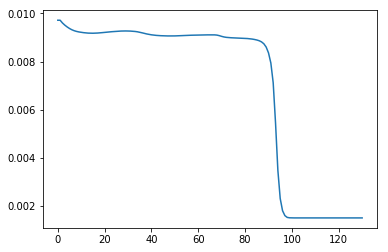

In [77]:
plt.plot(rawData[345,4,:])

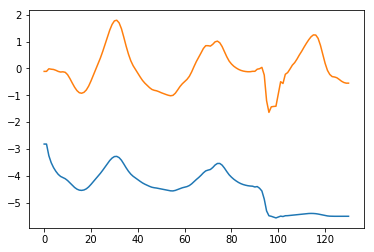

In [83]:
plt.plot(np.arange(131),rawData[345,1,:],np.arange(131),rawDataNorm[345,1,:])

In [0]:
np.clip(rawData,a_min=0,a_max=None)

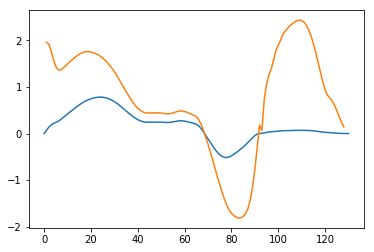

In [84]:
plt.plot(np.arange(131),rawData[345,2,:],np.arange(131),rawDataNorm[345,2,:])

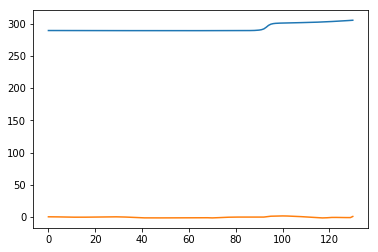

In [85]:
plt.plot(np.arange(131),rawData[345,3,:],np.arange(131),rawDataNorm[345,3,:])

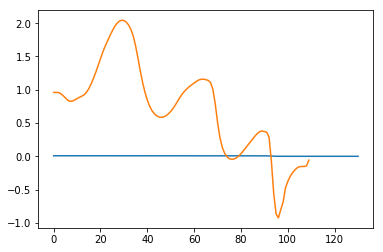

In [86]:
plt.plot(np.arange(131),rawData[345,4,:],np.arange(131),rawDataNorm[345,4,:])

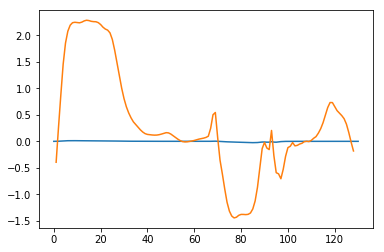

In [87]:
plt.plot(np.arange(131),rawData[345,5,:],np.arange(131),rawDataNorm[345,5,:])